## Cooking with ClarityNLP - Session #4

In this session of Cooking with ClarityNLP, we'll introduce integrations with OMOP and OHDSI. The main purpose is to introduce working with structured and unstructured data in one. We'll show how you can enhance vocabulary in ClarityNLP by using the OMOP vocabulary, how you can build more complete phenotypes using both structured and unstructured data, and how to export ClarityNLP results back to your OMOP database.

In [3]:
# Import dependencies
%matplotlib inline
import pandas as pd
pd.set_option('display.width',100000)
pd.set_option('max_colwidth',4000)
import matplotlib.pyplot as plt
from matplotlib_venn import venn2

import claritynlp_notebook_helpers as claritynlp

ClarityNLP notebook helpers loaded successfully!


### MIMIC
In most of our Cooking sessions, we will use the MIMIC data. The MIMIC-III Critical Care Database is data set containing information about ICU patients who stayed at the Beth Israel Deaconess Hospital between 2001 and 2012. MIMIC-III has multiple types of clinical observational data, including text. It has been de-identified for research use. Unlike most public clinical data sets, unstructured text is available in the MIMIC-III database, making it suitable for our research

## Introduction to OHDSI / OMOP

OHDSI is an international consortium focused on improving the reproducibility of health analytics using observational data. One of the most significant contributions of OHDSI is the democratization of analytics through user-friendly design tools for creating and evaluating phenotypes. 

The initial focus of OHDSI phenotypes has been primarily structured data such as diagnosis codes, procedure codes, drug codes and so forth. More recently the OMOP common data model has introduced an NLP table which offers the ability to incorporate more information from unstructured sources. But an important gap that remains is the ability to develop phenotypes that dynamically incorporate both structured and unstructured data in a reproducible and shareable format. In this cooking session, we would like to demonstrate some of the mechanisms by which ClarityNLP can be combined with OHDSI to create more robust cohort definitions and convert data from unstructured to structured form.

#### Quick note on Setup

This tutorial assumes you have an [OHDSI WebAPI](https://github.com/OHDSI/WebAPI) up and running. We also use the [OHDSI Atlas](https://github.com/OHDSI/Atlas) tool for exploration. Visit [OHDSI.org](https://www.ohdsi.org/) to get up and going with OHDSI.

To setup OHDSI in ClarityNLP, your ClarityNLP instance needs access to your OHDSI WebAPI, set the `OHDSI_WEBAPI_URL` in your `.env` file. For example:                                                                                    

```
OHDSI_WEBAPI_URL=https://gt-apps.hdap.gatech.edu/ohdsi/WebAPI
```


### Use Case 1: Introduction to Synonyms in OHDSI

In this section, we'll explore term expansion in ClarityNLP. There are a variety of ways to expand terms in ClarityNLP, which we have introduced in previous sessions, and is documented [here](https://claritynlp.readthedocs.io/en/latest/user_guide/nlpql/macros.html). In the following example, we look at conditions related to having a low platelet count or Thrombocytopenia.

In ClarityNLP, we'll look for mentions of some of the [related conditions](https://www.healthline.com/health/thrombocytopenia#symptoms) to having a low platelet count:
* **red, purple, or brown bruises, which are called purpura**
* **a rash with small red or purple dots called petechiae**
* **nosebleeds**
* bleeding gums
* bleeding from wounds that lasts for a prolonged period or doesn’t stop on its own
* heavy menstrual bleeding
* bleeding from the rectum
* blood in stool
* blood in urine

For this demo, we'll just pick a few to test ClarityNLP.

In [54]:
nlpql = '''

phenotype "LowPlateletTerms";

termset BruiseTerms:[
VerbInflections("bruise"),
OHDSI.Synonyms("purpura"),
OHDSI.Synonyms("contusion")
];

termset BleedingTerms:[
OHDSI.Synonyms("epistaxis"),
"nosebleed", "nosebleeds", "nosebleeding",
"nose bleed", "nose bleeds", "nose bleeding",
OHDSI.Synonyms("petechia")
];


'''

expanded_nlpql = claritynlp.run_term_expansion(nlpql)
print(expanded_nlpql)



phenotype "LowPlateletTerms";

termset BruiseTerms:[
"bruise","bruised","bruises","bruising",
"peliosis","purpura","purpura (finding)","purpura (morphologic abnormality)",
"bruise","bruising","contusion","contusion (disorder)"
];

termset BleedingTerms:[
"epistaxis",
"nosebleed", "nosebleeds", "nosebleeding",
"nose bleed", "nose bleeds", "nose bleeding",
"petechia","petechia (morphologic abnormality)","petechiae","petechial haemorrhage","petechial hemorrhage"
];





Since we're using SNOMED as the vocabulary, we get some extra terms that aren't as useful, but we can filter those out. If you have access to OHDSI Atlas, you can explore the OMOP vocabulary in finer detail, and can provide different terms that might not be found using `Synonyms`, `Ancestors` or `Descendants`.  

* [Georgia Tech Atlas](https://gt-apps.hdap.gatech.edu/ohdsi/atlas/#/concept/37220014)
* [Public Atlas](http://www.ohdsi.org/web/atlas/)

![atlas_vocab.png](assets/atlas_vocab.png)

### Use case 2: Comparing Structured Data with Symptoms found in ClarityNLP

In this next example, we'll look at symptoms found in ClarityNLP compared to structured data. In this case, we're looking at low platelet count. We define that in OHDSI simply by the following:

* A blood platelet count < 100

In ClarityNLP, we'll look for mentions of some of the [related conditions](https://www.healthline.com/health/thrombocytopenia#symptoms) to having a low platelet count that we identified above.

In [14]:
nlpql = '''

phenotype "LowPlateletConditions";

documentset DocNotes:
    Clarity.createReportTypeList(["Physician "]);
    
termset BruiseTerms:[
"bruise","bruised","bruises","bruising",
"peliosis","purpura",
"bruise","bruising","contusion"
];

termset BleedingTerms:[
"epistaxis",
"nosebleed", "nosebleeds", "nosebleeding",
"nose bleed", "nose bleeds", "nose bleeding",
"petechia","petechiae","petechial haemorrhage","petechial hemorrhage",
"nasal haemorrhage","nasal hemorrhage"
];

define hasBruising:
Clarity.ProviderAssertion({
  termset: [BruiseTerms],
  documentset: [DocNotes]
});

define hasBleeding:
Clarity.ProviderAssertion({
  termset: [BleedingTerms],
  documentset: [DocNotes]
});

context Patient;

define final hasLowPlateletConditions:
    where hasBruising AND hasBleeding;
'''
run_result, main_csv, intermediate_csv, luigi = claritynlp.run_nlpql(nlpql)

Job Successfully Submitted
{
    "intermediate_results_csv": "http://18.220.133.76:5000/job_results/539/phenotype_intermediate",
    "job_id": "539",
    "luigi_task_monitoring": "http://18.220.133.76:8082/static/visualiser/index.html#search__search=job=539",
    "main_results_csv": "http://18.220.133.76:5000/job_results/539/phenotype",
    "phenotype_config": "http://18.220.133.76:5000/phenotype_id/539",
    "phenotype_id": "539",
    "pipeline_configs": [
        "http://18.220.133.76:5000/pipeline_id/740",
        "http://18.220.133.76:5000/pipeline_id/741"
    ],
    "pipeline_ids": [
        740,
        741
    ],
    "results_viewer": "?job=539",
    "status_endpoint": "http://18.220.133.76:5000/status/539"
}


In [43]:
inter_csv_df = pd.read_csv('http://18.220.133.76:5000/job_results/539/phenotype_intermediate')
inter_csv_df.head()

,_id,batch,concept_code,end,experiencer,inserted_date,job_id,negation,nlpql_feature,owner,...,report_id,report_type,section,sentence,solr_id,source,start,subject,temporality,term
0,5bbce10e142135056b0876e3,1025,-1,73,Patient,2018-10-09 17:10:38.002000,539,Affirmed,hasBruising,claritynlp,...,507228,Physician,ASSESSMENT_AND_PLAN,"24 y/o female s/p blunt head injury, negative head CT, possible contusion vs. developing SDH",507228,MIMIC,64,31628,Historical,contusion
1,5bbce10e14213505650876e3,1475,-1,83,Patient,2018-10-09 17:10:38.502000,539,Affirmed,hasBruising,claritynlp,...,533632,Physician,RADIOGRAPHIC_STUDIES,CXR Residual consolidation in the left lower lung could be atelectasis or contusion or aspiration.,533632,MIMIC,74,42067,Recent,contusion
2,5bbce10f142135056e0876e3,525,-1,191,Patient,2018-10-09 17:10:39.177000,539,Affirmed,hasBruising,claritynlp,...,588420,Physician,CEREBRAL_ANGIOGRAPHY,There has been progression of intracranial hemorrhage since prior study of 4 hours earlier: new foci of parenchymal hemorrhage in the right frontal cortex inferiorly could be due to contusion.,588420,MIMIC,182,42052,Historical,contusion
3,5bbce10f142135056e0876e4,525,-1,61,Patient,2018-10-09 17:10:39.181000,539,Affirmed,hasBruising,claritynlp,...,588420,Physician,CEREBRAL_CT,"little interval change in right frontal hemorrhagic contusion with surrounding edema, subarachnoid blood also appears unchanged [**4-8**] CT angio",588420,MIMIC,52,42052,Recent,contusion
4,5bbce10f14213505650876e4,1475,-1,107,Patient,2018-10-09 17:10:39.290000,539,Affirmed,hasBruising,claritynlp,...,536242,Physician,HISTORY_PRESENT_ILLNESS,"Head CT shows an old posterior right temporal hypodensity, likely encephalomalacia from her prior contusion.",536242,MIMIC,98,12925,Historical,contusion


In [16]:
main_csv_df = pd.read_csv('http://18.220.133.76:5000/job_results/539/phenotype')
main_csv_df.head()

,_id,_id_x,_id_y,context_type,job_date,job_id,nlpql_feature,nlpql_feature_x,nlpql_feature_y,owner,phenotype_final,phenotype_id,raw_definition_text,report_date_x,report_date_y,report_id_x,report_id_y,sentence_x,sentence_y,subject
0,5bbcebe11421350f220876e3,5bbce13c142135056b0876f6,5bbce4ef14213508f10876ea,subject,2018-10-09 17:56:49.197000,539,hasLowPlateletConditions,hasBruising,hasBleeding,539,True,539,hasBruising AND hasBleeding,2199-08-05T00:00:00Z,2199-08-05T00:00:00Z,627661,628692,"Per OSH notes, the patient initially presented yesturday afternoon to OSH ED complaining of left ankle and tibial pain and bruising after hitting his leg on the car door.","COUGHING BLOOD -- unclear whether blood represents hemoptysis, GI bleeding/hematemesis, or epistaxis.",39166
1,5bbcebe11421350f220876e4,5bbce13c142135056b0876f6,5bbce4f514213508f10876ef,subject,2018-10-09 17:56:49.197000,539,hasLowPlateletConditions,hasBruising,hasBleeding,539,True,539,hasBruising AND hasBleeding,2199-08-05T00:00:00Z,2199-08-05T00:00:00Z,627661,628688,"Per OSH notes, the patient initially presented yesturday afternoon to OSH ED complaining of left ankle and tibial pain and bruising after hitting his leg on the car door.","COUGHING BLOOD -- unclear whether blood represents hemoptysis, GI bleeding/hematemesis, or epistaxis.",39166
2,5bbcebe11421350f220876e5,5bbce13c142135056b0876f6,5bbce4fb14213508fc0876e4,subject,2018-10-09 17:56:49.197000,539,hasLowPlateletConditions,hasBruising,hasBleeding,539,True,539,hasBruising AND hasBleeding,2199-08-05T00:00:00Z,2199-08-05T00:00:00Z,627661,628507,"Per OSH notes, the patient initially presented yesturday afternoon to OSH ED complaining of left ankle and tibial pain and bruising after hitting his leg on the car door.",Given dark NG lavage and small amount suctioned (20cc).This GI collected blood may be secondary to ingested hempotysis source or from a nasopharyngeal /nosebleed in the setting of an elevated INR vs. true pulmonary source and overt hemoptysis.,39166
3,5bbcebe11421350f220876e6,5bbce13c142135056b0876f6,5bbce8b41421350c4f087713,subject,2018-10-09 17:56:49.197000,539,hasLowPlateletConditions,hasBruising,hasBleeding,539,True,539,hasBruising AND hasBleeding,2199-08-05T00:00:00Z,2199-08-05T00:00:00Z,627661,627661,"Per OSH notes, the patient initially presented yesturday afternoon to OSH ED complaining of left ankle and tibial pain and bruising after hitting his leg on the car door.","COUGHING BLOOD -- unclear whether blood represents hemoptysis, GI bleeding/hematemesis, or epistaxis.",39166
4,5bbcebe11421350f220876e7,5bbce13c142135056b0876f6,5bbce8b61421350c4f087714,subject,2018-10-09 17:56:49.197000,539,hasLowPlateletConditions,hasBruising,hasBleeding,539,True,539,hasBruising AND hasBleeding,2199-08-05T00:00:00Z,2199-08-05T00:00:00Z,627661,627663,"Per OSH notes, the patient initially presented yesturday afternoon to OSH ED complaining of left ankle and tibial pain and bruising after hitting his leg on the car door.","COUGHING BLOOD -- unclear whether blood represents hemoptysis, GI bleeding/hematemesis, or epistaxis.",39166


We can see that from the ClarityNLP [result viewer](http://18.220.133.76:8200/?job=538), we have some patients who have potential for having low platelet count. Now, let's integrate an OHDSI cohort to see how the data sets compare.

![results_viewer.png](assets/results_viewer.png)

### Creating Cohorts from Structured Data

OHDSI Atlas has an extensive builder for building out cohorts on structured data. In this case, we'll look at patients who've had a platelet count using a platelet measure less than or equal to 100.
![low_platelet_cohort.png](assets/low_platelet_cohort.png)

In [17]:
# Low Platelet Cohort JSON
# OHDSI Cohorts can be shared via JSON, an example is shown here.
json = '''
{
  "ConceptSets": [
    {
      "id": 0,
      "name": "Platelets",
      "expression": {
        "items": [
          {
            "concept": {
              "CONCEPT_ID": 3024929,
              "CONCEPT_NAME": "Platelets [#/volume] in Blood by Automated count",
              "STANDARD_CONCEPT": "S",
              "INVALID_REASON": "V",
              "CONCEPT_CODE": "777-3",
              "DOMAIN_ID": "Measurement",
              "VOCABULARY_ID": "LOINC",
              "CONCEPT_CLASS_ID": "Lab Test",
              "STANDARD_CONCEPT_CAPTION": "Standard",
              "INVALID_REASON_CAPTION": "Valid"
            }
          }
        ]
      }
    }
  ],
  "PrimaryCriteria": {
    "CriteriaList": [
      {
        "Measurement": {
          "CodesetId": 0,
          "ValueAsNumber": {
            "Value": 100,
            "Op": "lte"
          }
        }
      }
    ],
    "ObservationWindow": {
      "PriorDays": 0,
      "PostDays": 0
    },
    "PrimaryCriteriaLimit": {
      "Type": "First"
    }
  },
  "QualifiedLimit": {
    "Type": "First"
  },
  "ExpressionLimit": {
    "Type": "First"
  },
  "InclusionRules": [],
  "CensoringCriteria": [],
  "CollapseSettings": {
    "CollapseType": "ERA",
    "EraPad": 0
  },
  "CensorWindow": {}
}
'''

### Comparing OHDSI and ClarityNLP data sets

Now let's explore OHDSI and ClarityNLP data sets. Note that we might not find much in common in here, because in ClarityNLP, we're looking at patients with a couple low platelet symptoms. While in OHDSI, we're looking at people who've been found to have a low platelet count.


We'll begin by loading up the OHDSI cohort into a data frame.

In [11]:
low_platelet_patients = pd.DataFrame(claritynlp.get_cohort_patients(356)['Patients'])
low_platelet_patients.head()

,cohortDefinitionId,cohortEndDate,cohortStartDate,subjectId
0,356,4515264000000,4512585600000,29821
1,356,4537900800000,4535222400000,38681
2,356,5180112000000,5173027200000,44187
3,356,4626633600000,4626201600000,10243
4,356,7280323200000,7276521600000,15859


In [39]:
low_platelet_patients.shape

(8031, 4)

In [40]:
inter_csv_df.shape

(4684, 24)

Note that the ClarityNLP data set has multiple patients because we're looking at each instance of bleeding or bruising (we'll fix that in a second). What else can we learn by comparing these 2 data sets?

In [18]:
def get_patient_sets(clarity_df, ohdsi_df):
    unique_clarity_patients = set(clarity_df['subject'])
    unique_ohdsi_patients = set(ohdsi_df['subjectId'])
    clarity_diff = unique_clarity_patients - unique_ohdsi_patients
    ohdsi_diff = unique_ohdsi_patients - unique_clarity_patients
    intersection = unique_clarity_patients & unique_ohdsi_patients
    print("Union :", len(unique_clarity_patients | unique_ohdsi_patients))
    print("Intersection :", len(intersection))
    print("Difference (OHDSI - ClarityNLP):", len(ohdsi_diff))
    print("Difference (ClarityNLP - OHDSI):", len(clarity_diff))
    venn2([unique_clarity_patients, unique_ohdsi_patients], set_labels=('ClarityNLP', 'OHDSI'))
    
    return unique_clarity_patients, unique_ohdsi_patients, clarity_diff, ohdsi_diff, intersection


ClarityNLP Patients with Bleeding or Bruising.
OHDSI Patients with Low Platelets.

Union : 8450
Intersection : 184
Difference (OHDSI - ClarityNLP): 7847
Difference (ClarityNLP - OHDSI): 419


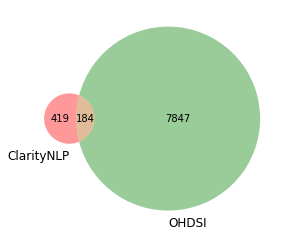

In [21]:
print('ClarityNLP Patients with Bleeding or Bruising.')
print('OHDSI Patients with Low Platelets.')
print()
unique_clarity_patients, unique_ohdsi_patients, clarity_diff, ohdsi_diff, intersection = get_patient_sets(inter_csv_df, low_platelet_patients)

So, we only found 184 patients with condition in ClarityNLP related to a low platelet count. What might be a reason the numbers are so low?

* We don't have notes on all the patients in MIMIC.
* We only look at Physician notes, maybe in the future we should expand that.
* We didn't specifically look for "low platelet" or even all the symptoms related to having a low platelet count.

Let's look at patients who had bleeding and bruising.

ClarityNLP Patients with Bleeding and Bruising.
OHDSI Patients with Low Platelets.

Union : 8053
Intersection : 22
Difference (OHDSI - ClarityNLP): 8009
Difference (ClarityNLP - OHDSI): 22


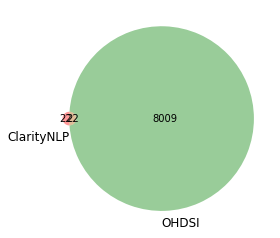

In [44]:
print('ClarityNLP Patients with Bleeding and Bruising.')
print('OHDSI Patients with Low Platelets.')
print()
unique_clarity_patients, unique_ohdsi_patients, clarity_diff, ohdsi_diff, intersection = get_patient_sets(main_csv_df, low_platelet_patients)

Note that the number of patients that were found to have bruising and bleeding in this document set is pretty small, but we can see half of them were in the OHDSI cohort and half of them were not.

This is an introductory example on how to compare OHDSI and ClarityNLP. We'll dig into further examples on this data and others on how ClarityNLP and OMOP integrate. 

### Use case 3: Bake-off

![cake.png](assets/cake.png)

Just kidding! No cake today, but occassionally you might want to compare unstructured and structured data on a more even playing field. Let's see what ClarityNLP can find, if we search provider assertions for low platelet count directly.

In [6]:
nlpql = '''

phenotype "LowPlateletPatients";

documentset Notes:
    Clarity.createReportTypeList(["Physician ", "Nursing", "Nursing/other", "Discharge summary"]);
    
termset LowPlateletTerms:[
"low platelet",
"low platelets",
"Thrombocytopenia"
];


define final lowPlateletCount:
Clarity.ProviderAssertion({
  termset: [LowPlateletTerms],
  documentset: [Notes]
});
'''
run_result, main_csv, intermediate_csv, luigi = claritynlp.run_nlpql(nlpql)

Job Successfully Submitted
{
    "intermediate_results_csv": "http://18.220.133.76:5000/job_results/541/phenotype_intermediate",
    "job_id": "541",
    "luigi_task_monitoring": "http://18.220.133.76:8082/static/visualiser/index.html#search__search=job=541",
    "main_results_csv": "http://18.220.133.76:5000/job_results/541/phenotype",
    "phenotype_config": "http://18.220.133.76:5000/phenotype_id/541",
    "phenotype_id": "541",
    "pipeline_configs": [
        "http://18.220.133.76:5000/pipeline_id/743"
    ],
    "pipeline_ids": [
        743
    ],
    "results_viewer": "?job=541",
    "status_endpoint": "http://18.220.133.76:5000/status/541"
}


In [13]:
bakeoff_main_csv_df = pd.read_csv('http://18.220.133.76:5000/job_results/541/phenotype')
bakeoff_main_csv_df.head()

,_id,batch,concept_code,end,experiencer,inserted_date,job_id,negation,nlpql_feature,owner,...,report_id,report_type,section,sentence,solr_id,source,start,subject,temporality,term
0,5bbcf6c7cfb1a701a85a9626,10200,-1,18,Patient,2018-10-09 18:43:19.044000,541,Affirmed,lowPlateletCount,claritynlp,...,559446,Physician,MENTAL_STATUS_PLAN,"# Thrombocytopenia: HIT antibody positive, off all heparin products, lines flushed yesterday.",559446,MIMIC,2,37566,Recent,Thrombocytopenia
1,5bbcf6c7cfb1a701a45a9626,200,-1,24,Patient,2018-10-09 18:43:19.970000,541,Affirmed,lowPlateletCount,claritynlp,...,1288091,Nursing/other,MICROBIOLOGY,Consistenly low platelet count but pt.refusing bone marrow bx.,1288091,MIMIC,12,6835,Recent,low platelet
2,5bbcf6c8cfb1a701a45a9627,200,-1,58,Patient,2018-10-09 18:43:20.172000,541,Affirmed,lowPlateletCount,claritynlp,...,1691225,Nursing/other,PULMONARY_REVIEW,I would hesitate to NT suction this pt due to low platelet count and known esophogeal varicies.,1691225,MIMIC,46,14178,Recent,low platelet
3,5bbcf6c8cfb1a701a45a9628,200,-1,12,Patient,2018-10-09 18:43:20.387000,541,Affirmed,lowPlateletCount,claritynlp,...,1310454,Nursing/other,DERMATOLOGICAL_REVIEW,Low Platelet - Dr. [**Last Name (STitle) 5263**] notify Dr. [**First Name (STitle) **] - 2 unit platelet to be transfuse.,1310454,MIMIC,0,9874,Recent,Low Platelet
4,5bbcf6c8cfb1a701a45a9629,200,-1,40,Patient,2018-10-09 18:43:20.662000,541,Affirmed,lowPlateletCount,claritynlp,...,1788915,Nursing/other,GENITOURINARY_REVIEW,"LOW GRADE TEMP, [** 254**], LOW PLATELET COUNT, AWAITING VATS PROCEDURE TOMORROW.",1788915,MIMIC,28,11187,Recent,LOW PLATELET


ClarityNLP Patients with Low Platelets.
OHDSI Patients with Low Platelets.

Union : 8436
Intersection : 985
Difference (OHDSI - ClarityNLP): 7046
Difference (ClarityNLP - OHDSI): 405


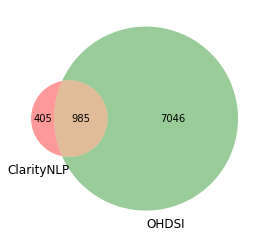

In [45]:
print('ClarityNLP Patients with Low Platelets.')
print('OHDSI Patients with Low Platelets.')
print()
unique_clarity_patients, unique_ohdsi_patients, clarity_diff, ohdsi_diff, intersection = get_patient_sets(bakeoff_main_csv_df, low_platelet_patients)

Let's evaluate some of the patients that ClarityNLP found that didn't have a low platelet count.

In [40]:
cd_list = list(clarity_diff)
cd_list[0:3]

[22533, 34826, 10259]

Here are some example notes:
    
##### Patient 22533:
```
3.  Thrombocytopenia: The patient's platelets count decreased
down to 53 upon admission, down from 81 on [**6-28**]. 
```
##### Patient 34826:
```
5. Thrombocytopenia
- Likely [**2-17**] infection. Will follow.
- Check coags to help r/o DIC; if plts decrease can  check
```
##### Patient 10259:
```
 during this admission, noted to have elevated uric acid level and low platelets with normal BP. 
```

We can see from these samples, that these appear to be valid cases. Why were they missed in the structured data? We could also add more terms to the OHDSI cohort to find more of the matches that ClarityNLP found. Perhaps, this data was only captured in the clinical notes. 

Now we can try to do a similar thing with patients in the OHDSI cohort but not in the ClarityNLP results.

In [41]:
od_list = list(ohdsi_diff)
od_list[0:3]

[1, 32771, 16388]

#### Wrapping up Bake-off
Patient 1 and 32771 only have a few notes each. Patient 16388 has 15 notes, but none of them mention low platelets or Thrombocytopenia.

Looking at 3 patients is obviously a very small sample, but it gives us an example that for many cases using structured and unstructured data will beneficially increase the cohort size. 

This gives us an example how to enhance and find additional patients using ClarityNLP, when we're trying to find additional criteria.


### Use case 4: Finding data in ClarityNLP about an OHDSI cohort

ClarityNLP also has the option to run on a specific set of patients. In this case, we have a cohort of patients with atrial fibrilation or rapid, irregular heart rate. Let's see what additional information we can extract from this data set.

![afib_cohort.png](assets/afib_cohort.png)

Since afib is related to heart rate, let's learn what vital signs we can extract from ClarityNLP, such as heart rate and blood pressure, e.g.

```
Vitals: Temp 100.2 HR 72 BP 184/56 RR 16 sats 96% on RA
```

In [51]:
# Let's get some counts on our Afib cohort
afib_patients = pd.DataFrame(claritynlp.get_cohort_patients(358)['Patients'])
afib_patients.head()

,cohortDefinitionId,cohortEndDate,cohortStartDate,subjectId
0,358,5419008000000,5415638400000,26080
1,358,5194108800000,5190566400000,7224
2,358,7280323200000,7276262400000,15859
3,358,5860944000000,5857920000000,15849
4,358,6186758400000,6183820800000,8203


In [52]:
afib_patients.shape

(10271, 4)

In [49]:
nlpql = '''
phenotype "AfibPatientsVitals";

cohort AfibPatients:OHDSI.getCohort(358);

termset HeartRateTerms:[
"hr",
"heart rate"
];

termset BPTerms:[
"blood pressure",
"bp"
];

define final HR:
  Clarity.ValueExtraction({
    cohort:AfibPatients,
    termset:[HeartRateTerms],
    minimum_value: "30",
    maximum_value: "200"
    });

define final BP:
  Clarity.ValueExtraction({
    cohort:AfibPatients,
    termset:[BPTerms],
    minimum_value: "30",
    maximum_value: "200"
    });



'''
run_result, main_csv, intermediate_csv, luigi = claritynlp.run_nlpql(nlpql)

Job Successfully Submitted
{
    "intermediate_results_csv": "http://18.220.133.76:5000/job_results/543/phenotype_intermediate",
    "job_id": "543",
    "luigi_task_monitoring": "http://18.220.133.76:8082/static/visualiser/index.html#search__search=job=543",
    "main_results_csv": "http://18.220.133.76:5000/job_results/543/phenotype",
    "phenotype_config": "http://18.220.133.76:5000/phenotype_id/543",
    "phenotype_id": "543",
    "pipeline_configs": [
        "http://18.220.133.76:5000/pipeline_id/746"
    ],
    "pipeline_ids": [
        746
    ],
    "results_viewer": "?job=543",
    "status_endpoint": "http://18.220.133.76:5000/status/543"
}


In [113]:
main_csv_df = pd.read_csv('http://18.220.133.76:5000/job_results/542/phenotype')
main_csv_df.head()

,_id,batch,concept_code,condition,dimension_X,dimension_Y,dimension_Z,end,inserted_date,job_id,...,source,start,subject,temporality,term,text,units,value,value1,value2
0,5bbd72f8e5f13d00805db115,59175,-1,RANGE,110.0,170.0,NaN,155,2018-10-10 03:33:12.890000,542,...,MIMIC,132,35089,NaN,NaN,HR,NaN,110.0,NaN,NaN
1,5bbd72f9e5f13d00805db116,59175,-1,EQUAL,92.0,-1.0,NaN,64,2018-10-10 03:33:13,542,...,MIMIC,59,31311,NaN,NaN,HR,NaN,92.0,NaN,NaN
2,5bbd72f9e5f13d00805db117,59175,-1,EQUAL,79.0,-1.0,NaN,32,2018-10-10 03:33:13.001000,542,...,MIMIC,27,31311,NaN,NaN,HR,NaN,79.0,NaN,NaN
3,5bbd72f9e5f13d00805db118,59175,-1,RANGE,90.0,100.0,NaN,42,2018-10-10 03:33:13.177000,542,...,MIMIC,30,34742,NaN,NaN,HR,NaN,90.0,NaN,NaN
4,5bbd72f9e5f13d007d5db115,57075,-1,EQUAL,60.0,-1.0,NaN,52,2018-10-10 03:33:13.168000,542,...,MIMIC,28,1200,NaN,NaN,HR,NaN,60.0,NaN,NaN


In [114]:
main_csv_df.shape

(12482, 31)

In [108]:
just_values = main_csv_df[['value', 'sentence']]
just_values.head(25)

,value,sentence
0,110.0,"67 y/o M presented to the EW after several days of N/V/D following chemo last Tuesday, in EW pt found to be febrile to 99.8 rectal, HR ranging from 110-170 new onset Afib with rvr, bp 110/68, lethargic though easily arousable, answering questions appropriately, given 3.5 L of IVF, with some effect on HR though per report pt continued to have a rate in the 150s, given vanco, cefepime, and flagyl, sating 94% on 2 liter via nasal cannula."
1,92.0,"Per their report, he had a fever there of 101.2, BP 79/54, HR 92, RR 34 and oxygen sat of 80% on RA."
2,79.0,"In the ED, T 100 rectally, HR 79, BP 81/23, RR 16 and O2 sat 100% on NC."
3,90.0,"bp remains stable, consistent HR 90s-100s."
4,60.0,AFTER REVERSAL AGENTS GIVEN HR DROPPED INTO LOW 60'S W DOWNWARD TRENDING BP.
5,90.0,Atrial fibrillation (Afib) Assessment: HR 90 s to low 100 s AF.
6,110.0,"HR cont be in 110-120 s and BP in 90- Action: Held PM and early morning dose of Lopressor [**1-26**] low BP, Dr [**Last Name (STitle) 995**]."
7,80.0,HX of prostate CA with mets Atrial fibrillation (Afib) Assessment: HR 80-90 s atrial fib Frequent PVC VSS Action: Remains off coumadin Response:
8,70.0,"Lopressor given IV with HR to 70-80 s, BP slowly dropped to initially to 80 s, Patient with increasing anxiety, pulled out aline."
9,80.0,"Neo gtt started with improved BP Response: BP now 110 s, HR 80 Plan: Continue to maintain BP >100. ?"


Now, that we've extracted some values on our cohort, we can explore just certain aspects of ClarityNLP results. We'll start with heart rate. 

We can also plot the histogram of heart rate values of our Afib patients. This gives us an idea of the distribution of our cohort, and if we had a control cohort, we could also compare against that cohort.

In [115]:
afibHR = main_csv_df[main_csv_df['nlpql_feature'] == 'HR']
afibHR.head()

,_id,batch,concept_code,condition,dimension_X,dimension_Y,dimension_Z,end,inserted_date,job_id,...,source,start,subject,temporality,term,text,units,value,value1,value2
0,5bbd72f8e5f13d00805db115,59175,-1,RANGE,110.0,170.0,NaN,155,2018-10-10 03:33:12.890000,542,...,MIMIC,132,35089,NaN,NaN,HR,NaN,110.0,NaN,NaN
1,5bbd72f9e5f13d00805db116,59175,-1,EQUAL,92.0,-1.0,NaN,64,2018-10-10 03:33:13,542,...,MIMIC,59,31311,NaN,NaN,HR,NaN,92.0,NaN,NaN
2,5bbd72f9e5f13d00805db117,59175,-1,EQUAL,79.0,-1.0,NaN,32,2018-10-10 03:33:13.001000,542,...,MIMIC,27,31311,NaN,NaN,HR,NaN,79.0,NaN,NaN
3,5bbd72f9e5f13d00805db118,59175,-1,RANGE,90.0,100.0,NaN,42,2018-10-10 03:33:13.177000,542,...,MIMIC,30,34742,NaN,NaN,HR,NaN,90.0,NaN,NaN
4,5bbd72f9e5f13d007d5db115,57075,-1,EQUAL,60.0,-1.0,NaN,52,2018-10-10 03:33:13.168000,542,...,MIMIC,28,1200,NaN,NaN,HR,NaN,60.0,NaN,NaN


In [116]:
afibHR.shape

(12482, 31)

Text(0.5,1,'Heart Rate of Afib Patients')

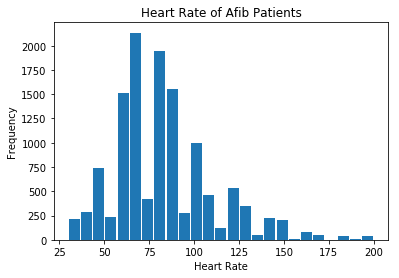

In [117]:
n, bins, patches = plt.hist(x=afibHR['value'], bins=25, rwidth=0.9)
plt.xlabel('Heart Rate')
plt.ylabel('Frequency')
plt.title('Heart Rate of Afib Patients')

### Use case 5: Exporting data from ClarityNLP back to OHDSI

From the examples above, we can see that ClarityNLP is effective at extracting features from clinical text. ClarityNLP can also write data back to an OMOP database. This is a push only function. As a general rule, data should be validated for accuracy before it is written back to the source database. 

For this feature, we'll run some NLPQL on patients with pneumonia and then extract temperature and use the Results Viewer to write the data back to OMOP.

In OMOP, we simply define these patients by having the condition pneumonia. The JSON is available below.

In [ ]:
'''
{
  "ConceptSets": [
    {
      "id": 0,
      "name": "PNA",
      "expression": {
        "items": [
          {
            "concept": {
              "CONCEPT_ID": 255848,
              "CONCEPT_NAME": "Pneumonia",
              "STANDARD_CONCEPT": "S",
              "INVALID_REASON": "V",
              "CONCEPT_CODE": "233604007",
              "DOMAIN_ID": "Condition",
              "VOCABULARY_ID": "SNOMED",
              "CONCEPT_CLASS_ID": "Clinical Finding",
              "STANDARD_CONCEPT_CAPTION": "Standard",
              "INVALID_REASON_CAPTION": "Valid"
            }
          }
        ]
      }
    },
    {
      "id": 1,
      "name": "Temp",
      "expression": {
        "items": [
          {
            "concept": {
              "CONCEPT_ID": 3020891,
              "CONCEPT_NAME": "Body temperature",
              "STANDARD_CONCEPT": "S",
              "INVALID_REASON": "V",
              "CONCEPT_CODE": "8310-5",
              "DOMAIN_ID": "Measurement",
              "VOCABULARY_ID": "LOINC",
              "CONCEPT_CLASS_ID": "Clinical Observation",
              "STANDARD_CONCEPT_CAPTION": "Standard",
              "INVALID_REASON_CAPTION": "Valid"
            }
          }
        ]
      }
    }
  ],
  "PrimaryCriteria": {
    "CriteriaList": [
      {
        "ConditionOccurrence": {
          "CodesetId": 0
        }
      }
    ],
    "ObservationWindow": {
      "PriorDays": 0,
      "PostDays": 0
    },
    "PrimaryCriteriaLimit": {
      "Type": "First"
    }
  },
  "AdditionalCriteria": {
    "Type": "ALL",
    "CriteriaList": [
      {
        "Criteria": {
          "Measurement": {
            "CodesetId": 1,
            "ValueAsNumber": {
              "Value": 100,
              "Op": "gt"
            }
          }
        },
        "StartWindow": {
          "Start": {
            "Coeff": -1
          },
          "End": {
            "Coeff": 1
          }
        },
        "Occurrence": {
          "Type": 2,
          "Count": 1
        }
      }
    ],
    "DemographicCriteriaList": [],
    "Groups": []
  },
  "QualifiedLimit": {
    "Type": "First"
  },
  "ExpressionLimit": {
    "Type": "First"
  },
  "InclusionRules": [],
  "CensoringCriteria": [],
  "CollapseSettings": {
    "CollapseType": "ERA",
    "EraPad": 0
  },
  "CensorWindow": {}
}
'''

In [121]:
# Let's view the Pneumonia Patients
pneumonia_patients = pd.DataFrame(claritynlp.get_cohort_patients(360)['Patients'])
pneumonia_patients.head()

,cohortDefinitionId,cohortEndDate,cohortStartDate,subjectId
0,360,5324227200000,5321289600000,43116
1,360,5180112000000,5173027200000,44187
2,360,5117385600000,5114361600000,14119
3,360,5419008000000,5415638400000,26080
4,360,7057324800000,7050153600000,39049


In [119]:
pneumonia_patients.shape

(4438, 4)

##### Integrating ClarityNLP

So, the pneumonia cohort has 4438 patients, let's see how many of those patients have a measurement of Temperature.

![pna_with_fever.png](assets/pna_with_fever.png)

In [122]:
pneumonia_fever_patients = pd.DataFrame(claritynlp.get_cohort_patients(359)['Patients'])
pneumonia_fever_patients.head()

""


In [123]:
pneumonia_fever_patients.shape

(0, 0)

So, the current cohort doesn't have any matching patients, let's use ClarityNLP to write back some Temperature results!

In [130]:
nlpql = '''
phenotype "PneumoniaPatientsTemp";

cohort PneumoniaPatients:
    OHDSI.getCohort(359);


termset TempTerms:[
"temperature",
"temp"
];

define Temp:
  Clarity.ValueExtraction({
    cohort:PneumoniaPatients,
    termset:[TempTerms],
    minimum_value: "96",
    maximum_value: "106"
    });

define final Fever:
    where Temp >= 100.4;

'''
run_result, main_csv, intermediate_csv, luigi = claritynlp.run_nlpql(nlpql)

Job Successfully Submitted
{
    "intermediate_results_csv": "http://18.220.133.76:5000/job_results/546/phenotype_intermediate",
    "job_id": "546",
    "luigi_task_monitoring": "http://18.220.133.76:8082/static/visualiser/index.html#search__search=job=546",
    "main_results_csv": "http://18.220.133.76:5000/job_results/546/phenotype",
    "phenotype_config": "http://18.220.133.76:5000/phenotype_id/546",
    "phenotype_id": "546",
    "pipeline_configs": [
        "http://18.220.133.76:5000/pipeline_id/749"
    ],
    "pipeline_ids": [
        749
    ],
    "results_viewer": "?job=546",
    "status_endpoint": "http://18.220.133.76:5000/status/546"
}


In [134]:
tmp_csv_df = pd.read_csv('http://18.220.133.76:5000/job_results/546/phenotype_intermediate')
tmp_csv_df[['value', 'sentence']].head(20)

,value,sentence
0,97.1,"RECEIVED FIRST DOSES OF EACH, PKU OBTAINED, INITIAL TEMP 97.1..PLACED ON WARMER WITH TEMP 98.4,"
1,98.4,"RECEIVED FIRST DOSES OF EACH, PKU OBTAINED, INITIAL TEMP 97.1..PLACED ON WARMER WITH TEMP 98.4,"
2,101.2,Temp spike 101.2.
3,101.2,"Temp spiked at midnoc 101.2 R, ( was 100.6 ax at same time)."
4,99.4,Unable to obtain sputum Response: Temp 99.4 ax at noon.
5,99.0,"Patient improved to 96% on 6L, HR 120s sinus, temp down to 99."
6,98.4,Vanco Response: Temp 98.4.
7,99.0,"Patient improved to 96% on 6L, HR 120s sinus, temp down to 99."
8,98.4,"Vanco , wean O2 to 2l NC Response: Temp 98.4."
9,102.9,Pt given 650mg of acetaminophen for temp of 102.9 PO.


Now that ClarityNLP has found some results on our pneumonia patients, using the results viewer, we can export these results back to OMOP.

For our purposes, we'll use concept id 3020891 in OMOP as a measurement, which maps to 8310-5 in LOINC as `Body Temperature`.

![clarity_export.png](assets/clarity_export.png)

In [135]:
# Now let's reload the data set, and see if we have any patients loaded into OHDSI with fever and pneumonia.
pneumonia_fever_patients = pd.DataFrame(claritynlp.get_cohort_patients(359)['Patients'])
pneumonia_fever_patients.head()

""


In [ ]:
pneumonia_fever_patients.shape